<a href="https://colab.research.google.com/github/JairEsc/Aprendizaje/blob/main/CAMDA/SVM_NN_datos_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio de clasificación
### Utilizando datos de CAMDA 2023, considerando como variable de clasificación "City", consideraremos un modelo híbrido de máquinas de soporte vectorial y redes neuronales.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
otus=pd.read_csv('camda_relative.csv', index_col=0, low_memory=False)
print(otus.shape)
otus.head()

(286, 18295)


,ID_city,City,Latitude,Longitude,Climate,Year,468,469,28090,2708348,...,1146874,1519389,12480,1131,2886895,546184,12330,1922682,1513254,1922952
ID,,,,,,,,,,,,,,,,,,,,,
CAMDA23_MetaSUB_gCSD16_AKL_10,AKL,Auckland,-36.75,174.75,Cfb,2016,0.048249,10.696605,14.560432,1.407184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_11,AKL,Auckland,-36.75,174.75,Cfb,2016,0.038155,0.527739,0.041985,0.006187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_12,AKL,Auckland,-36.75,174.75,Cfb,2016,0.002185,0.234138,0.051282,0.004188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_13,AKL,Auckland,-36.75,174.75,Cfb,2016,0.000142,0.014304,0.010763,0.001360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_14,AKL,Auckland,-36.75,174.75,Cfb,2016,0.002103,0.061997,0.079509,0.003771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocesamiento de la base:
Encontramos unas entradas de tipo string. Removemos las columnas correspondientes

In [4]:
X_names = otus.drop(['ID_city','City','Latitude','Longitude','Climate','Year'],axis=1).columns
drops=[]
for name in X_names:
    if('\x10.001308923774823973' in np.array(otus[name]) or '0.001215429219479$037' in np.array(otus[name]) ):
        otus=otus.drop(name,axis=1)
        X_names=X_names.drop(name)
        drops.append(name)
#Aquí podriamos hacer selección de muestras. E.g. aquellas etiquetas con al menos $N$ muestras.
print("Después: ",otus.shape)

Después:  (286, 18293)


Exploramos el balance de clases a considerar

<ipython-input-5-8202315d1e17>:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  plt.bar(otus['City'].value_counts().index.ravel(),otus['City'].value_counts(),)


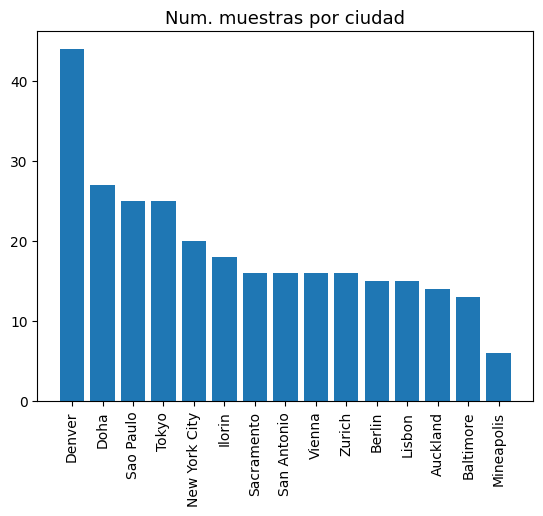

In [5]:
plt.bar(otus['City'].value_counts().index.ravel(),otus['City'].value_counts(),)
plt.title("Num. muestras por ciudad", fontsize=13)
plt.tick_params(axis='x', labelrotation=90)

plt.show()

### El shape=(286,18293) nos indica que hay 286 muestras, repartidas en 15 ciudades.

In [6]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 27.5 MB/s eta 0:00:00


In [7]:
import contextily as ctx
import geopandas as gpd
import numpy as np
conteo_por_ciudad=[]
for p in otus['City'].value_counts():
  conteo_por_ciudad+=list(np.repeat(p,p))

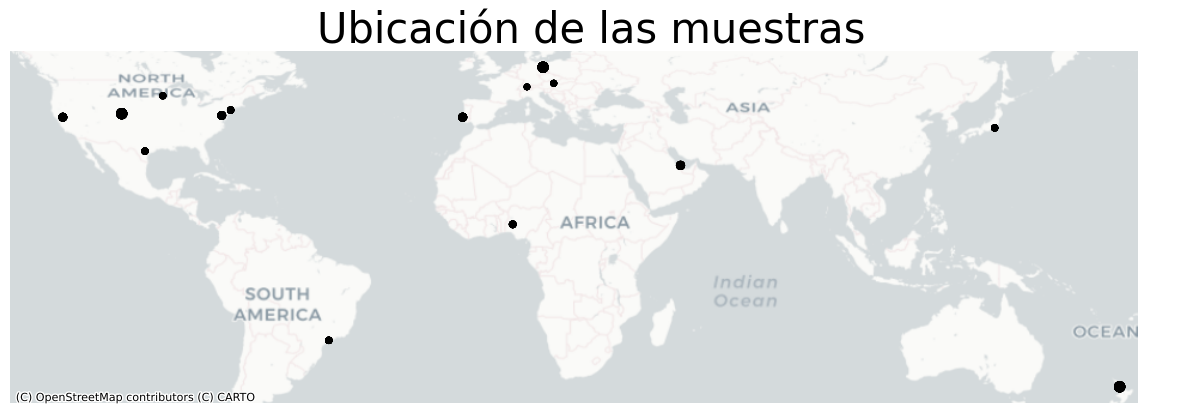

In [8]:
otus_gdf = gpd.GeoDataFrame(otus.copy(), geometry=gpd.points_from_xy(otus['Longitude'], otus['Latitude']), crs='EPSG:4326')
fig, ax = plt.subplots(1, figsize=(15, 15))
otus_gdf.plot(marker='.', c='black', ax=ax, markersize=(np.array(conteo_por_ciudad)/np.max(conteo_por_ciudad))*200, zorder=1)
plt.title("Ubicación de las muestras",fontsize=30)
plt.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## Primera clasificación.
Al ser "Denver" la ciudad con más muestras, utilizamos el método de soporte vectorial

In [10]:
X = otus[X_names]
Y_total_city=np.array(otus['City']).ravel()
otus['City_binary']=['Denver' if x=='Denver' else 'No-Denver' for x in otus['City']]
Y_total_Denver=np.array(otus['City_binary']).ravel()
X_train, X_test, y_train_id, y_test_id = train_test_split(X, np.arange(0,len(Y_total_city)), test_size=0.3, random_state=0)

In [11]:
Y_train=np.array(otus['City']).ravel()[y_train_id]
Y_test=np.array(otus['City']).ravel()[y_test_id]

<ipython-input-12-8bb33b4d9717>:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  plt.bar(otus['City_binary'].value_counts().index.ravel(),otus['City_binary'].value_counts(),)


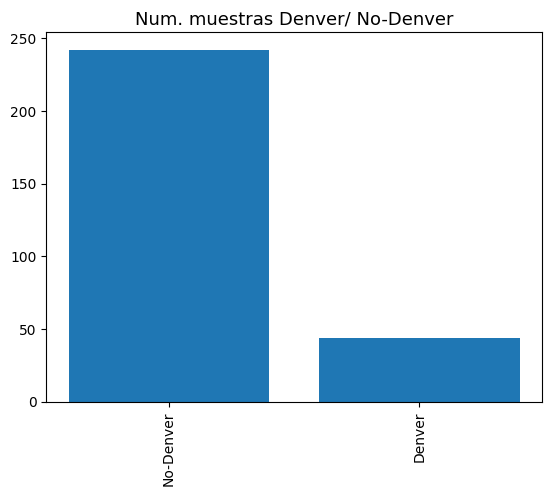

In [12]:
plt.bar(otus['City_binary'].value_counts().index.ravel(),otus['City_binary'].value_counts(),)
plt.title("Num. muestras Denver/ No-Denver", fontsize=13)
plt.tick_params(axis='x', labelrotation=90)

plt.show()

In [13]:
import seaborn as sns
sns.set()
from sklearn.svm import SVC # Support vector classifier
from sklearn.datasets import make_blobs

In [14]:
model_svm = SVC(kernel='linear', C=1E10)
Y_train_binary=['Denver' if x=='Denver' else 'No-Denver' for x in Y_train]
le = preprocessing.LabelEncoder()
le.fit(Y_train_binary)
#le.classes_
y_cat_city = le.transform(Y_train_binary)
model_svm.fit(X_train, Y_train_binary)


SVC(C=10000000000.0, kernel='linear')

In [15]:
y_pred=model_svm.predict(X_test)
Y_test_binary=['Denver' if x=='Denver' else 'No-Denver' for x in Y_test]
print(metrics.classification_report(Y_test_binary, y_pred))

              precision    recall  f1-score   support

      Denver       0.53      0.90      0.67        10
   No-Denver       0.99      0.89      0.94        76

    accuracy                           0.90        86
   macro avg       0.76      0.90      0.80        86
weighted avg       0.93      0.90      0.91        86



El modelo SVM clasifica como Denver o No-Denver con 0.76-0.93 de precisión.

## A continuación definimos el modelo de multilayer perceptron para clasificar a las ciudades No-Denver

In [16]:
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models
import tqdm
from time import time

In [17]:
_,idx = np.unique(Y_total_city,return_inverse=True)
from keras.utils import to_categorical
Y_total=to_categorical(idx)
X_train_NN=X_train[Y_train!='Denver']
X_test_NN=X_test[Y_test!='Denver']
Y_train_NN=[x for x in Y_train if x!='Denver']
Y_test_NN=[x for x in Y_test if x!='Denver']
_,idx = np.unique(Y_train_NN,return_inverse=True)
Y_train_NN=to_categorical(idx)
_,idx = np.unique(Y_test_NN,return_inverse=True)
Y_test_NN=to_categorical(idx)

In [18]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(18287,), name='Input_Layer'))#Obligatoria
model.add(layers.Dense(10, activation='linear'))# Numero de capas ocultas: Opcional
model.add(layers.Dense(10, activation='tanh'))# Numero de neuronas en cada capa: Opcional
model.add(layers.Dense(14, activation='Softmax', name='Output_Layer'))#Obligatoria
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
import time
tic = time.time()

history=model.fit(x = X_train_NN,
           y = Y_train_NN,
          validation_data=[X_test_NN, Y_test_NN],batch_size=50,
           epochs=250,
           verbose=0,shuffle=True,)

print('seconds=', time.time()-tic)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                182880    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 Output_Layer (Dense)        (None, 14)                154       
                                                                 
Total params: 183144 (715.41 KB)
Trainable params: 183144 (715.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
seconds= 35.28642559051514


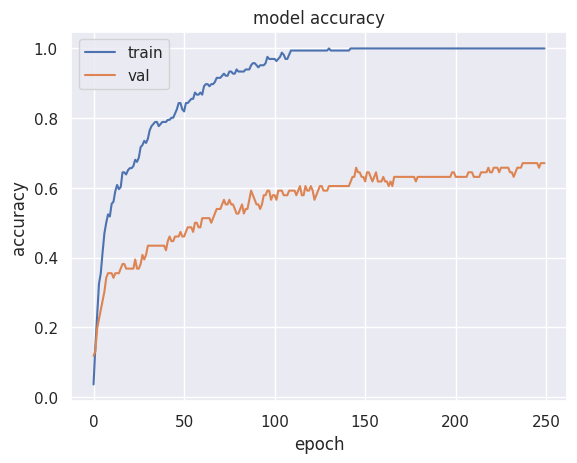

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
primera_prediccion=model_svm.predict(X_test)
indices = [ind for ind, ele in enumerate(primera_prediccion) if ele == 'No-Denver']
segunda_prediccion=np.argmax(model.predict(X_test.iloc[indices]),axis=1)
for i in range(len(indices)):
    primera_prediccion[indices[i]]=segunda_prediccion[i]
ultima_prediccion=[x if x=='Denver' else _[int(x)] for x in primera_prediccion]


3/3 [==============================] - 0s 5ms/step


## Calcular la precisión

In [21]:
print(metrics.classification_report(Y_test, ultima_prediccion))

               precision    recall  f1-score   support

     Auckland       1.00      0.50      0.67         4
    Baltimore       0.38      0.75      0.50         4
       Berlin       0.80      1.00      0.89         4
       Denver       0.53      0.90      0.67        10
         Doha       0.57      0.57      0.57         7
       Ilorin       1.00      0.83      0.91         6
       Lisbon       1.00      0.50      0.67         4
   Mineapolis       1.00      1.00      1.00         2
New York City       1.00      0.75      0.86         4
   Sacramento       0.43      0.75      0.55         4
  San Antonio       0.62      0.71      0.67         7
    Sao Paulo       0.71      0.71      0.71        14
        Tokyo       0.67      0.33      0.44         6
       Vienna       0.00      0.00      0.00         3
       Zurich       1.00      0.43      0.60         7

     accuracy                           0.66        86
    macro avg       0.71      0.65      0.65        86
 weighte

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como nota sin pruebas: El modelo híbrido funciona mejor que los modelos por separados, SVM y NN, lo cuales se probaron anteriormente y se descartó por su baja precisión.